## GMM clustering demo

Although scenario discovery often relies on explicit performance thresholds to identify a subset of cases of interest (Bryant & Lempert, 2010), the exploratory nature of this analysis would make it more difficult to select unambiguous thresholds across the selected indicators. As suggested by Gerst et al. (2013), multidimensional clustering may instead provide a more flexible way to generate scenarios by identifying groups of experiments which yield similar behaviours and outcomes. For the purposes of this analysis, the scikit-learn Python library was therefore used to fit a Gaussian mixture model (GMM) (McLachlan & Peel, 2000) to the data. This technique essentially assumes that the samples of interest are generated by a mixture of an arbitrary number of Gaussian distributions; expectation maximization can then be used to assign each sample to the distribution to which it most likely belongs, generating a finite number of clusters. Conventional scenario discovery techniques (PRIM/CART) can then be used to identify which uncertainties contribute to the multidimensional cluster classification.

We first create helper functions to visualize the results with a parallel coordinate plot:

In [41]:
%matplotlib inline

from __future__ import division
import csv

import scipy.stats as stats
import matplotlib.ticker as ticker
from matplotlib import cm
import seaborn as sns

from ema_workbench.em_framework import ModelEnsemble, ParameterUncertainty, CategoricalUncertainty, Outcome
from ema_workbench.util import ema_logging, load_results, save_results
from ema_workbench.connectors.excel import ExcelModelStructureInterface
from ema_workbench.analysis import plotting, plotting_util

sns.set_style('white')

def normalize(data):
    minima = np.min(data, axis=0)
    maxima = np.max(data, axis=0)
    a = 1/(maxima-minima)
    b = minima/(minima-maxima)
    data = a * data + b                    
    return data


def make_kde(data):
    nr_points = 250
    grid = np.linspace(0, 1, nr_points)
    
    kde = stats.kde.gaussian_kde(data.T)
    x, y = np.meshgrid(grid, grid)
    grid_coords = np.append(x.reshape(-1,1),y.reshape(-1,1),axis=1)
    z = kde(grid_coords.T)
    z = z.reshape(nr_points,nr_points)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(np.flipud(z), cmap=cm.coolwarm)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig


def make_kde_scaled(class_data, full_data):
    nr_points = 250
    grid = np.linspace(0, 1, nr_points)
    
    x, y = np.meshgrid(grid, grid)
    grid_coords = np.append(x.reshape(-1,1),y.reshape(-1,1),axis=1)
    
    kde_class = stats.kde.gaussian_kde(class_data.T)
    z_class = kde_class(grid_coords.T)
    z_class = z_class.reshape(nr_points,nr_points)
    
    kde_full = stats.kde.gaussian_kde(full_data.T)
    z_full = kde_full(grid_coords.T)
    z_full = z_full.reshape(nr_points,nr_points)

    # rescale
    class_max = np.max(z_class)
    loc = np.where(z_class==class_max)
    full_at_loc = z_full[loc]
    
    z_class = (full_at_loc/class_max ) * z_class
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(np.flipud(z_class), vmax=np.max(z_full), cmap=cm.coolwarm)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig


def make_parallel_plot(data, labels):

    fig = plt.figure()
    axes = []
    
    for i in range(1, data.shape[1]):
        ax = fig.add_subplot(1,data.shape[1]-1,i,  ylim=(-0.1,1.1))
        axes.append(ax)
        ax.set_xlim([i,i+1])
        ax.xaxis.set_major_locator(ticker.FixedLocator([i]))
        ax.xaxis.set_ticklabels([labels[i-1]])
        ax.xaxis.set_tick_params(bottom=False, top=False)
        
        ax.yaxis.set_ticks([])
        ax.text(i, 1.01, "1", va="bottom", ha="center")
        ax.text(i, -0.01, "0", va="top", ha="center")
        
        ax.spines['left'].set_bounds(0, 1)
        ax.spines['right'].set_bounds(0, 1)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    ax.spines['right'].set_bounds(0, 1)
    ax.xaxis.set_major_locator(ticker.FixedLocator([i, i+1]))
    ax.xaxis.set_ticklabels(labels[i-1:i+1])
    ax.text(i+1, 1.01, "1", va="bottom", ha="center")
    ax.text(i+1, -0.01, "0", va="top", ha="center")
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label2On=True
    
    plt.subplots_adjust(wspace=0)
    
    return fig, axes


def plot_data_parallel(data, labels, classes):
    C = set(classes)
    C = list(C)
    C.sort()
    
    norm_data = normalize(data)
    figures = []
    for index, Ci in enumerate(C):
        fig, axes = make_parallel_plot(data, labels)
        fig.suptitle('class {}'.format(Ci), fontsize=20)
        figures.append(fig)
        logical = classes==Ci
        
        for i,j in zip(range(data.shape[1]-1),range(1,data.shape[1])):
            ax = axes[i]
            y = norm_data[logical==False, i:j+1]
            x = np.tile([i+1,j+1], (data.shape[0], 1))
            ax.plot(x.T, y.T, c='#C0C0C0')
            
            y = norm_data[logical, i:j+1]
            x = np.tile([i+1,j+1], (data.shape[0], 1))
            ax.plot(x.T, y.T, c='b')
            
    return figures

## Model selection

In order to determine an efficient number of clusters that can be found in the data, we can use an information criterion. An information criterion considers the quality of fit of the model and the number of free parameters used to achieve this fit - the lower the value, the better. The graph shows two criteria for the Bayesian Information Criterion (BIC) and Aikake's Information Criterion (AIC), fitting a GMM over a range of 1 to 10 possible clusters. Although the information criteria do not give a clear minimum value over this range, 5 clusters seems to be a good compromise based on the BIC.

For this simple example, we use three outcomes of interest to generate the clusters.

In [15]:
import numpy as np

experiments, outcomes = load_results(r'D:/marcjaxarozen/SandboxData/LHS_750-3.tar.gz')

oois = ['wells with [IsActive = 1]','CO2Savings','ExpectedROI']

data = np.array([[outcomes[oois[0]][:,-1][i],outcomes[oois[1]][:,-1][i],outcomes[oois[2]][:,-1][i]] for i in range(len(experiments))])
data = normalize(data)

In [16]:
from sklearn import mixture

aic = []
bic = []
max_components = 10
x = [x for x in range(1,max_components)]

for nc in x:
    g = mixture.GMM(n_components=int(nc), n_iter=500)
    g.fit(data)
    if g.converged_:
        aic.append(g.aic(data))
        bic.append(g.bic(data))
    else:
        aic.append(None)
        bic.append(None)

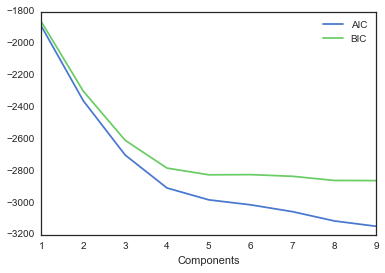

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, aic, label='AIC')
ax.plot(x, bic, label='BIC')
ax.legend(loc='best')
ax.set_xlabel('Components')

plt.show()

## Cluster visualization

To get a feel for how the data is being clustered, we use a kernel density estimate; a PCA projection can first be applied in the case of higher-dimensional data. 

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(data)
pca_data = pca.transform(data)
pca_data = normalize(pca_data)

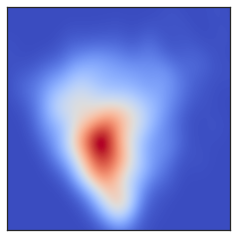

In [43]:
make_kde(pca_data)

plt.show()

We then apply the GMM to create 5 clusters.

In [31]:
n_clusters = 5

g = mixture.GMM(n_components=n_clusters, n_iter=500)
g.fit(data)
pred = g.predict(data)

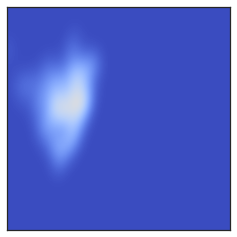

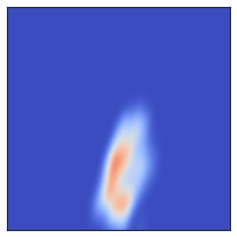

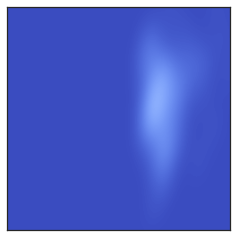

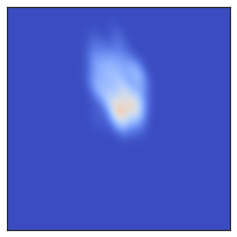

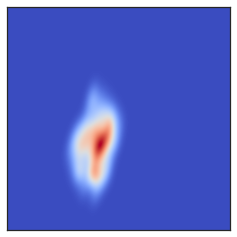

In [44]:
for i in range(n_clusters):
    logical = pred==i
    class_data = pca_data[logical]
    make_kde_scaled(class_data, pca_data)
    plt.show()

Which combination of outcomes of interest is captured by each of these clusters? To make this clear, we can use a parallel coordinate plot with normalized values. All the data is visualized in grey, and the cluster is superimposed in blue on top.

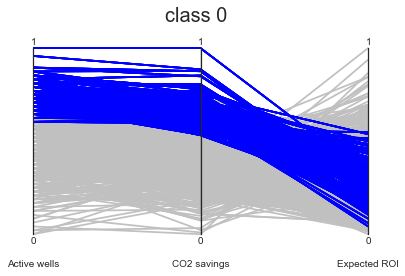

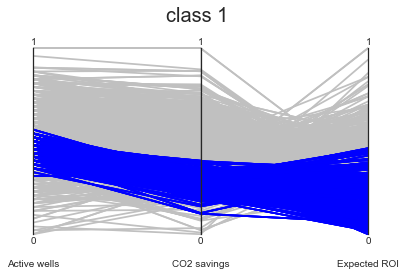

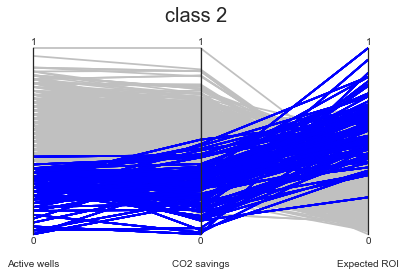

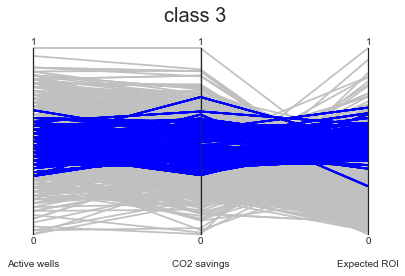

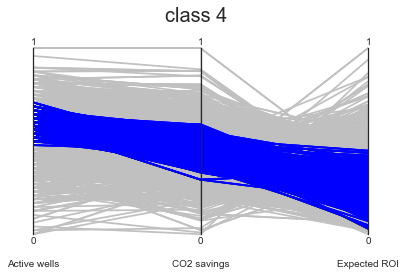

In [47]:
labels = ['Active wells','CO2 savings','Expected ROI']

plot_data_parallel(data, labels, pred)
plt.show()

Similarly, we can visualize the clusters with a pairwise scatter plot.

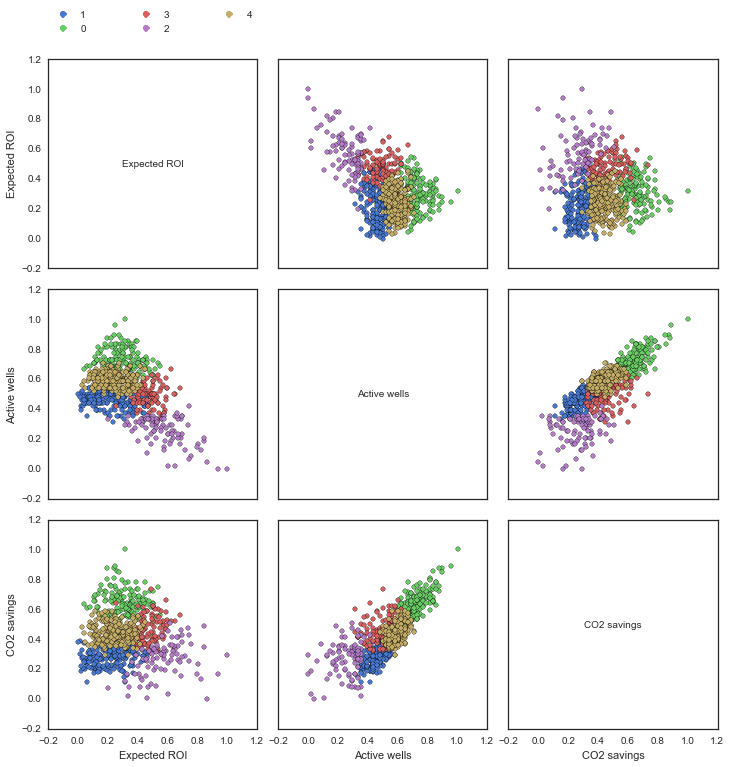

In [49]:
from ema_workbench.analysis.pairs_plotting import pairs_scatter


header = ['wells with [IsActive = 1]','CO2Savings','ExpectedROI']
labels = {'SubsurfaceUse':'Fraction of subsurface used','wells with [IsActive = 1]':'Active wells','CO2Savings':'CO2 savings','ExpectedROI':'Expected ROI'}

temp_outcomes = {header[i]:data[:, i] for i in range(len(header))}
temp_experiments = pred.astype(np.str).view([('classes', np.str)])

temp_results = temp_experiments, temp_outcomes

fig, axes = pairs_scatter(temp_results, group_by='classes',
                          grouping_specifiers=set(temp_experiments['classes']),
                          ylabels=labels,
                          filter_scalar=False)

fig.set_size_inches(12,12,forward=True)
plt.show()

## PRIM on clusters

The clustering seems to give reasonably consistent results. We can then use PRIM to find which combinations of uncertain inputs tend to be associated with a given cluster classification, focusing on clusters 0 and 1.

In [50]:
import ema_workbench.analysis.prim as prim
from functools import partial

class_outcomes = {'classes':pred}
results = (experiments, class_outcomes)

def classify(outcomes, class_nr=0):
    class_info = outcomes['classes']
    classes = np.zeros(class_info.shape)
    classes[class_info==class_nr] = 1
    
    return classes

### For cluster 0:

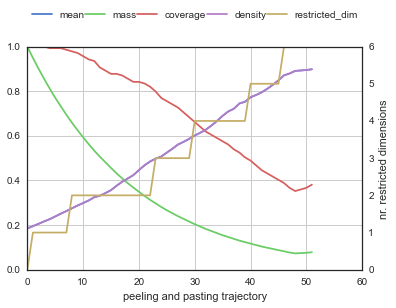

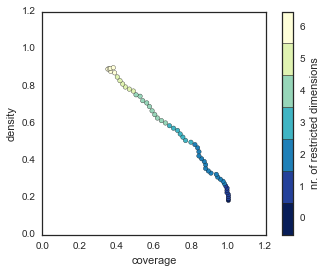

In [51]:
cf = partial(classify, class_nr=0)

prim_obj = prim.setup_prim(results, cf, threshold=0.5, threshold_type=1)
box = prim_obj.find_box()
box.show_ppt()
box.show_tradeoff()

plt.show()

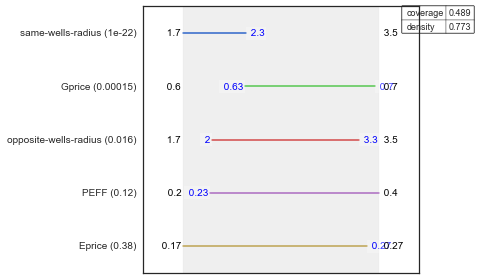

In [52]:
box.inspect(i=40, style='graph')
plt.show()

### For cluster 1:

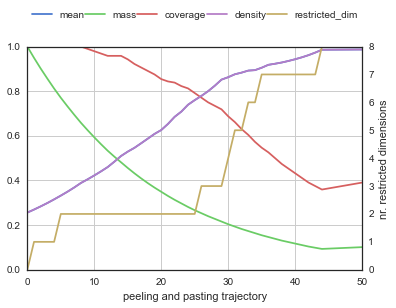

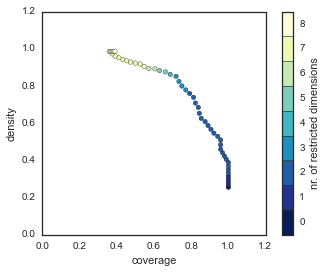

In [53]:
cf = partial(classify, class_nr=1)

prim_obj = prim.setup_prim(results, cf, threshold=0.5, threshold_type=1)
box = prim_obj.find_box()
box.show_ppt()
box.show_tradeoff()

plt.show()

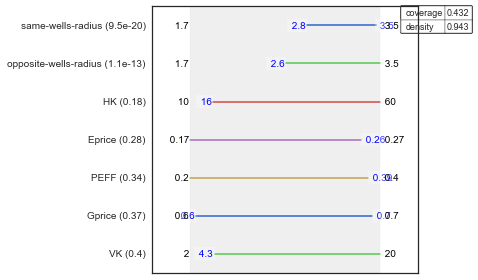

In [54]:
box.inspect(i=40, style='graph')
plt.show()